In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [5]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]


for r in range(5):
    participants_dictionary=[]
    for i in range(len(participants)):

        train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                          raw_user_fold,
                                                                                          participants,
                                                                                          batch_size=batch_size,
                                                                                          transpose_channels=transpose_channels)

        classifier= EEGNet(
            chunk_size=input_dim[1],
            num_electrodes=input_dim[0],
            num_classes=classes,
            kernel_1= 32,
            kernel_2=32,
            F1=8,
            F2=16,
            dropout=0.5
        ).to(DEVICE)


    #     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)

        criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
    #     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))

        saved_dir= f"./EEG/saved_models/Userfold/run{r}"
        nonlinear_func= LSTM_nonlinear_func(input_dim[0]).to(DEVICE)
        model = EEGNet_NeuralFS_HP_Wrapper(DEVICE, classifier, input_dim,
                                    nonlinear_func=nonlinear_func
                                     ).to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
        scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)


#         train_func= eeg_train
#         model.training_procedure(iteration=n_epochs,
#                                         train_dataloader=train_dataloader,
#                                          val_dataloader=val_dataloader,
#                                          print_cycle=2,
#                                          path=f"./dictionary/intermdiate_dicts",
#                                          loss_func=criterion,
#                                          optimiser=optimizer, #scheduler=scheduler,
#                                          train_func=train_func
#                                         )
#         if model.epoch == n_epochs+1:
#             EPOCH= n_epochs
#         else:
#             EPOCH= model.epoch

#         torch.save(model.state_dict(), 
#                os.path.join(
#                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-NFS_Multivariate-e{EPOCH}.pt"
#                )
#         )

#         pickle.dump( model.return_pairwise_weights(), 
#                     open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-NFS_Multivariate-w-e{EPOCH}.pkl", "wb") 
#                    )    

    # OR
        model.load_state_dict(
        torch.load(
            open(
                os.path.join(
                    saved_dir, f"Userfold-{participants[i]}-LSTM_EEGNet-NFS_Multivariate-e{n_epochs}.pt"
                ), "rb"
            )
                  )
        )


        prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)

        ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])

        c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
        print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
        b_acc_list.append(b_acc)
        c0_acc_list.append(c0_acc)
        c1_acc_list.append(c1_acc)
        participants_dictionary.append(dictionary)
#     pickle.dump(participants_dictionary, open(f"{saved_dir}/participant_dictionary-LSTM_EEGNet-NFS_Multivariate.pkl","wb"))


tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


107 20

c0_acc 0.963963963963964 , c1_acc 0.4 , b_acc 0.681981981981982
113 2

c0_acc 0.9826086956521739 , c1_acc 0.03773584905660377 , b_acc 0.5101722723543889
112 8

c0_acc 0.9105691056910569 , c1_acc 0.1509433962264151 , b_acc 0.530756250958736
125 8

c0_acc 0.9541984732824428 , c1_acc 0.14285714285714285 , b_acc 0.5485278080697928
113 4

c0_acc 0.9658119658119658 , c1_acc 0.08163265306122448 , b_acc 0.5237223094365951
120 6

c0_acc 0.96 , c1_acc 0.12 , b_acc 0.54
113 11

c0_acc 0.904 , c1_acc 0.19642857142857142 , b_acc 0.5502142857142858
126 3

c0_acc 1.0 , c1_acc 0.05084745762711865 , b_acc 0.5254237288135594
131 9

c0_acc 0.9849624060150376 , c1_acc 0.16363636363636364 , b_acc 0.5742993848257006
128 9

c0_acc 0.9922480620155039 , c1_acc 0.15254237288135594 , b_acc 0.5723952174484299
110 9

c0_acc 0.9243697478991597 , c1_acc 0.1875 , b_acc 0.5559348739495799
119 18

c0_acc 0.9754098360655737 , c1_acc 0.3333333333333333 , b_acc 0.6543715846994536
118 14

c0_acc 0.959349593495935 ,

     accuracy  f1-score
S01  0.776398  0.748837
S02  0.702381  0.613095
S03  0.704545  0.641758
S04  0.695187  0.621696
S05  0.680723  0.580696
S06  0.720000  0.649385
S07  0.690608  0.641696
S08  0.686486  0.597177
S09  0.734043  0.670042
S10  0.718085  0.640483
S11  0.718563  0.655864
S12  0.784091  0.751153
S13  0.720670  0.657239
S14  0.718232  0.656726
S15  0.699454  0.627562
S16  0.688525  0.570428
S17  0.746988  0.707257
S19  0.673913  0.577389
S20  0.722222  0.676715


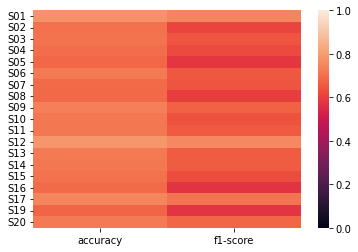

     class0 f1-score  class1 f1-score
S01         0.854839         0.513514
S02         0.818841         0.166667
S03         0.816901         0.235294
S04         0.813115         0.173913
S05         0.808664         0.036364
S06         0.830450         0.196721
S07         0.802817         0.282051
S08         0.807947         0.147059
S09         0.837662         0.264706
S10         0.827362         0.231884
S11         0.827839         0.229508
S12         0.862319         0.500000
S13         0.826389         0.285714
S14         0.824742         0.281690
S15         0.814815         0.202899
S16         0.815534         0.000000
S17         0.839695         0.400000
S19         0.801325         0.090909
S20         0.823944         0.342105


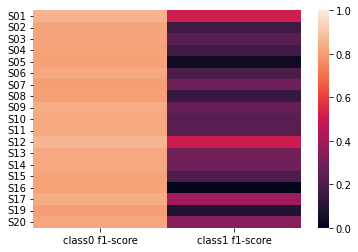

In [6]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [7]:
start=-0.5
step=1.5/(188-1)
timestep_labels=[]
for i in range(input_dim[1]):
    timestep_labels.append(round(start+step*i,3))
    
# timestep_labels

In [8]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [9]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-LSTM_EEGNet-NFS_Multivariate-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

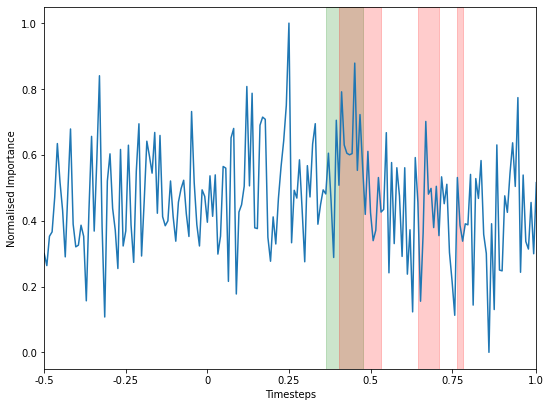

In [10]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(8,6))


scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(0).reshape(-1,1))
df= pd.DataFrame(scaled_avg_w)

plt.plot(df)
plt.xlabel("Timesteps")
plt.axvspan(107,121, color="green", alpha=0.2)
plt.axvspan(112,128, color="red", alpha=0.2)
plt.axvspan(142,150, color="red", alpha=0.2)
plt.axvspan(157,159, color="red", alpha=0.2)
plt.xticks([0,31,62,93,124,155,187],[-0.5, -0.25, 0, 0.25, 0.5, 0.75, 1.0])
plt.ylabel("Normalised Importance")
plt.margins(x=0)
matplotlib.rcParams.update({"font.size":18})
plt.tight_layout()

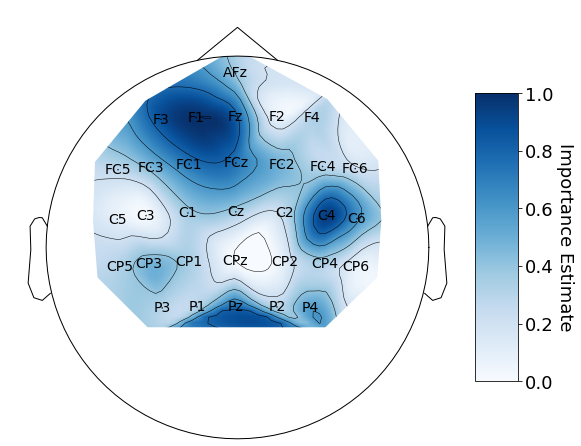

In [11]:
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.sum(1).reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)